# Accessing, Analyzing, & Visualizing TEMPO data through ArcGIS Image Services Programmatically

**Overview**
Selected TEMPO data have been processed into free, publicly available ArcGIS image services that provide pre-filtered, analysis-ready imagery/data.

This notebook illustrates the following:

* Choose a TEMPO image service to query
* Select time period and point (X,Y) of interest
* View data values for point of interest in a table
* Chart returned values for point of interest
* View imagery for the time period of interest in interactive mapper

**Why ArcGIS image services?** Each TEMPO ArcGIS image service is hosted at a service URL, which has several built-in functions provided through the [ArcGIS image service REST API](https://developers.arcgis.com/rest/services-reference/enterprise/image-service/). These functionalities can be accessed via webpage interfaces or called programatically, providing ways to access, analyze, and display the TEMPO data.

### Prerequisites
Note: ESRI software/licenses are NOT required to access the services via the interfaces or programatically. No GIS software is required to access these TEMPO image services (although there are many methods to use these services in GIS).

**Required:**
- Basic Python knowledge (variables, loops, functions)
- Familiarity with TEMPO instrument and data products

**Python Libraries:**
- [matplotlib](http://matplotlib.org/) - for creating plots and visualizations
- [numpy](https://numpy.org/) - for numerical operations
- [ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet/blob/master/python/ipyleaflet/README.md) - for visualization in interactive mapper
- [requests](https://github.com/psf/requests) - for sending HTTP requests to service API


### Data & Scope
Each TEMPO ArcGIS image service has a portal page with detailed descriptions on the service, the filtering applied, geographic and temporal coverage, as well as access to the online map viewer to view the image service. It is strongly recommended to read over the service description to ensure understanding of the data.

The TEMPO image services are available in the Esri [Living Atlas of the World](https://livingatlas.arcgis.com/en/browse/?q=tempo#q=tempo&d=2).


The example in this notebook uses:
- **Product**: TEMPO_NO2_L3_V04 (Level-3 gridded NO₂ tropopsheric column)
- **Resolution**: approximately 2.1 km × 4.4 km, hourly during daylight
- **Coverage**: North America
- **Example region**: Colorado, United States

*Methods apply to other TEMPO products (formaldehyde, ozone, etc.) and regions within North America.*

TEMPO Version 04 (V04) data are available from September 17, 2025 to present. The previous TEMPO data version (V03) was released publicly on May 24, 2024, and cover the time period from August 2, 2023 to September 16, 2025. All observations since the beginning of the mission are being reprocessed with V04 algorithms, with V04 products becoming publicly available in this service as they are reprocessed. Once the V03 data reprocessing is completed, the V03 service will be deprecated.

### Notebook Author / Affiliation
- Author: Atmospheric Science Data Center
- Questions? Please post questions on the [NASA Earthdata Forum](https://forum.earthdata.nasa.gov/)

# 1. Setup

### 1.1 Install Python packages

In [1]:
#Install Python packages if not available
#!pip install --quiet ipywidgets nodejs traitlets numpy pandas matplotlib

### 1.2 Import Python libraries

In [2]:
#For accessing data and creating chart
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from dateutil.relativedelta import relativedelta
import time
from datetime import datetime, timezone

#For creating interactive mapper
from ipyleaflet import Map, ImageService, basemaps,  WidgetControl
from ipywidgets import SelectionSlider, Layout, Label, VBox
from datetime import datetime, timezone
from ipywidgets import Output, HTML

#Set dataframe view options to ensure all rows appear (optional)
pd.set_option('display.max_rows', None)

### 1.3 Enable function to convert between human-readable dates and Unix timestamps
The TEMPO image services store the timestamp of each data scan as a Unix timestamp (e.g., 1752582321), which is the number of seconds since January 1, 1970 UTC. As these integers are not intuitive, we will use two custom functions to convert between Unix timestamps and human-readable date time strings.

In [3]:
#function to take input time as string and convert to integer of seconds since unix epoch UTC (Jan 1, 1970)
def convert_to_milliseconds(date_time_str):
    """Converts a date-time string in 'YYYY-MM-DD HH:MM:SS' format to milliseconds since epoch."""
    inputDate = dt.datetime.strptime(date_time_str, "%Y-%m-%d %H:%M:%S")
    return int(inputDate.replace(tzinfo=timezone.utc).timestamp() * 1000)

#function to take input time as integer of seconds since unix epoch UTC (Jan 1, 1970) and convert to string in 'YYYY-MM-DDTHH:MM:SSZ' format
def convert_from_milliseconds(milliseconds_since_epoch):
    """Converts milliseconds since epoch to a date-time string in 'YYYY-MM-DDTHH:MM:SSZ' format."""
    inputDateMilli = datetime.fromtimestamp((milliseconds_since_epoch)/ 1000, tz=timezone.utc)
    return inputDateMilli.strftime('%Y-%m-%dT%H:%M:%SZ')


# 2. User selections
Users can select variable, time, and point (X,Y) of interest or use default options. Several of the following sections allow users to choose between various options to tailor this code to their desired analysis. These sections have a default option that will be used if no changes are made. To select one of the other available options, users must adjust which lines of code are commented out (the # at the beginning of the code line) as noted in the instructions for the section. 

### 2.1 Choose TEMPO product/variable of interest

The default is TEMPO NO2 tropospheric column. Users may instead select formaldehyde (HCHO) total column or total column ozone (only one service/variable can be selected at a time).

In [4]:
# Select service URL and variable
'''Note: Only one image_service_url and corresponding variable_name can be used at a time. The other options should be commented out.'''

# Option 1: NO2 Image Service (V04 data; data range: September 17, 2025 - present) (deafault variable)
image_service_url = "https://gis.earthdata.nasa.gov/image/rest/services/C3685896708-LARC_CLOUD/TEMPO_NO2_L3_V04_HOURLY_TROPOSPHERIC_VERTICAL_COLUMN/ImageServer"
variable_name = "NO2_Troposphere"

# Option 2: Formaldehyde Image Service v4
#image_service_url = "https://gis.earthdata.nasa.gov/image/rest/services/C3685897141-LARC_CLOUD/TEMPO_HCHO_L3_V04_HOURLY_VERTICAL_COLUMN/ImageServer"
#variable_name = "HCHO"

# Option 3: Ozone Image Service v4
# image_service_url = "https://gis.earthdata.nasa.gov/image/rest/services/C3685896625-LARC_CLOUD/TEMPO_O3TOT_L3_V04_HOURLY_OZONE_COLUMN_AMOUNT/ImageServer"
# variable_name = "Ozone_Column_Amount"

#Option 4: NO2 image service (V03 data; data range: August 2, 2023 - September 16, 2025)
#image_service_url = "https://gis.earthdata.nasa.gov/image/rest/services/C2930763263-LARC_CLOUD/TEMPO_NO2_L3_V03_HOURLY_TROPOSPHERIC_VERTICAL_COLUMN/ImageServer"
#variable_name = "NO2_Troposphere"

#Option 5: Formaldehyde image service (V03 data; data range: August 2, 2023 - September 16, 2025)
#image_service_url = "https://gis.earthdata.nasa.gov/image/rest/services/C2930761273-LARC_CLOUD/TEMPO_HCHO_L3_V03_HOURLY_VERTICAL_COLUMN/ImageServer"
#variable_name = "HCHO"

#Option 6: Ozone image service (V03 data; data range: August 2, 2023 - September 16, 2025)
#image_service_url = "https://gis.earthdata.nasa.gov/image/rest/services/C2930764281-LARC_CLOUD/TEMPO_O3TOT_L3_V03_HOURLY_OZONE_COLUMN_AMOUNT/ImageServer"
#variable_name = "Ozone_Column_Amount"

### 2.2 Choose time period of interest

There are two options:
* Option 1 (default): Time period is yesterday (last 24 hours from present)
* Option 2: Manually select any time period within scope of TEMPO mission (August 2, 2023 - present)

Note: User must comment out the option that is not in use. By default, Option 2 is commented out.

In [5]:
# Choose starting and ending dates to run against

yesterday = dt.datetime.today() - dt.timedelta(days=1)
today = dt.datetime.today()

#Option 1 (Default): Yesterday - today NOTE: converts local computer time to UTC
'''Note: If using Option 2, comment out the two lines below:'''
start_date_time_str = str(dt.datetime(yesterday.year,yesterday.month,yesterday.day))
end_date_time_str = str(dt.datetime(today.year,today.month,today.day, today.hour))

#OR

#Option 2: Select specifc time period of interest'''
'''Note: If using Option 1, comment out the two lines below:'''
#start_date_time_str = "2025-05-06 0:01:00" #in 'YYYY-MM-DD HH:MM:SS' format "2025-04-20 12:00:00"
#end_date_time_str = "2025-05-08 05:00:00" #in 'YYYY-MM-DD HH:MM:SS' format "2025-05-25 12:00:00"

# Convert user input dates to milliseconds since epoch
start_time = convert_to_milliseconds(start_date_time_str)
end_time = convert_to_milliseconds(end_date_time_str)

print(f"The time period of interest has been defined as: Start = {start_date_time_str} ({start_time}); End: = {end_date_time_str} ({end_time})")

The time period of interest has been defined as: Start = 2026-02-04 00:00:00 (1770163200000); End: = 2026-02-05 14:00:00 (1770300000000)


### 2.3 Choose point of interest

User may select one coordinate pair (X,Y) as a point of interest. Data values for this point will be returned when the image service is queried. (X = longitude, Y = latitude)

In [6]:
#User chooses X,Y point of interest
'''Note: Replace coordinate with desired point.
Coordinate pair should be within quotation marks and have a comma between longitude and latitude values. Ex: "-84,37"
This variable is for the parameter "geometry" in the the URL service call below.'''
coor_pts = "-104.676, 39.856" # Denver Airport


# 3. Identify number and timestamp of TEMPO scans in time period of interest

The timestamp of each TEMPO scan is stored as a dimension in the image service and can be accessed by sending a Multidimensional Info request to the service URL.

In [7]:
#Create url for multidimensional info request
dim_info_url = f"{image_service_url}/multidimensionalInfo"

# Make request to service API
dim_info = requests.get(dim_info_url, params={"f": "json"}).json()
all_times = dim_info["multidimensionalInfo"]["variables"][0]["dimensions"][0]["values"]

# Filter to timestamps within the desired range and print count of scans found
timestamps = [t for t in all_times if start_time <= t <= end_time]
print("Number of TEMPO scans:", len(timestamps))

# Iterate through TEMPO scans and print timestamps as Unix epoch and date string
for t in timestamps:
    date_strings = convert_from_milliseconds(t)
    print(t, " ", date_strings)

Number of TEMPO scans: 11
1770210146000   2026-02-04T13:02:26Z
1770212554000   2026-02-04T13:42:34Z
1770214962000   2026-02-04T14:22:42Z
1770222162000   2026-02-04T16:22:42Z
1770225762000   2026-02-04T17:22:42Z
1770229362000   2026-02-04T18:22:42Z
1770232962000   2026-02-04T19:22:42Z
1770236562000   2026-02-04T20:22:42Z
1770240162000   2026-02-04T21:22:42Z
1770243762000   2026-02-04T22:22:42Z
1770246170000   2026-02-04T23:02:50Z


# 4. Retreive data values for point of interest for selected time period

Data values for a selected X,Y point can be accessed by sending a Get Samples request to the service URL and returned in a json.
The data are iterated through and values added to a dataframe.
The dataframe is then viewed as a table.

### 4.1 Get Samples request

The user provided information above (variable, time, X,Y point) are used to create a Get Samples request, which is sent to the service API. The data response is then stored in a json to access.

In [8]:
# Create URL for Get Samples request
base_url = image_service_url+"/getSamples/"
params = {
    "geometry": coor_pts, #Parameter that uses user's chosen lat/lon point
    "geometryType": "esriGeometryPoint",
    "sampleDistance": "",
    "sampleCount": "",
    "mosaicRule": f'{{"multidimensionalDefinition":[{{"variableName":"{variable_name}"}}]}}', #Parameter that uses user's chosen service variable
    "pixelSize": "",
    "returnFirstValueOnly": "false",
    "interpolation": "RSP_BilinearInterpolation",
    "outFields": "",
    "sliceId": "",
    "time": f"{start_time},{end_time}", #Parameter that uses user's chosen time period
    "f": "pjson"
}

# Make the request to the service API
response = requests.get(base_url, params=params)
data = response.json()

### 4.2 Extract data into a dataframe

The returned json contains the variable, timestamps, and data values for the TEMPO scans in the selected time period. Not all scans in the selected time period may have data for the selected X,Y point. The retrieved data are iterated through to find which scans had data for the selected X,Y point and adding those data values with their corresponding timestamps to a dataframe. The dataframe is displayed in a table format.

In [9]:
# Extract relevant information into a DataFrame
samples = []
for sample in data.get("samples", []):
    attributes = sample.get("attributes", {})
    var_value = sample.get("value")
    std_time = attributes.get("StdTime")
    
    # Only include the sample if it has a valid value for the variable of interest
    '''Note: this will result in timeslices being excluded if there are no data for the point of interest.
    Code may be modified to see all timestamps (i.e., include TEMPO scans where there are no data).'''
    if var_value:
        samples.append({
            "StdTime": std_time,
            variable_name: float(var_value)  # Convert to float
        })

# Convert the list to a DataFrame
df = pd.DataFrame(samples)

# Check if dataframe is empty. If not empty, convert StdTime from Unix timestamp (milliseconds) to datetime and print dataframe
if df.empty:
  print(f"No {variable_name} data found between {start_date_time_str} - {end_date_time_str} for point ({coor_pts}).")
else:
  df['StdTime'] = pd.to_datetime(df['StdTime'], unit='ms')
  print(df)

              StdTime  NO2_Troposphere
0 2026-02-04 16:22:42     4.875013e+15
1 2026-02-04 17:22:42     4.986164e+15
2 2026-02-04 18:22:42     5.116155e+15
3 2026-02-04 19:22:42     5.192751e+15
4 2026-02-04 20:22:42     5.494409e+15
5 2026-02-04 21:22:42     4.966968e+15
6 2026-02-04 22:22:42     4.121501e+15


### 4.3 Display the data in a chart

The data in the dataframe can be displayed in a chart. The chart can be exported for later use (this option is commented out by default).

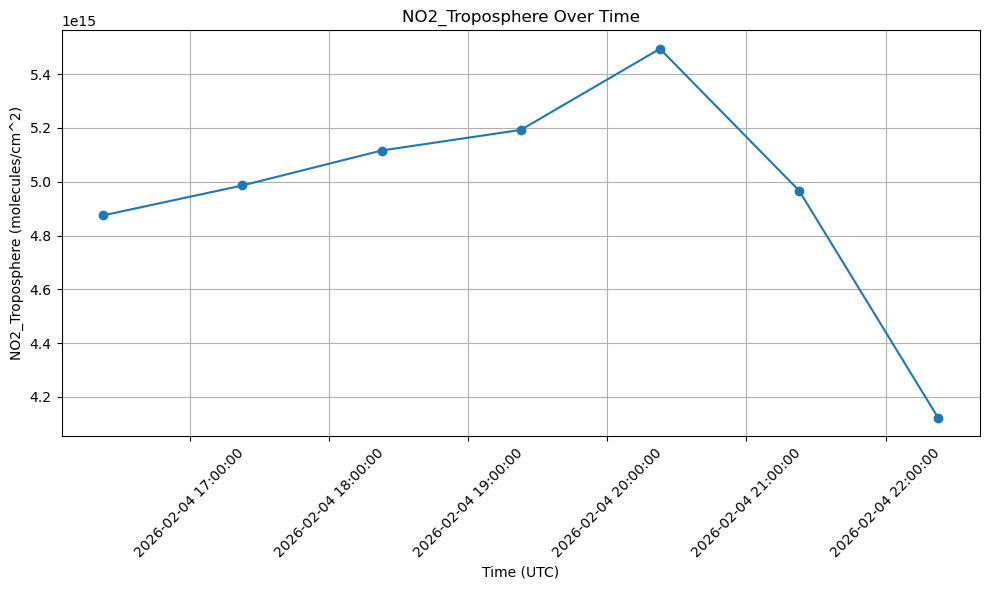

In [10]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['StdTime'], df[variable_name], marker='o', linestyle='-')

#Set title and labels--user may change
plt.title(f'{variable_name} Over Time') #User may change title as desired
plt.xlabel('Time (UTC)')
plt.ylabel(f'{variable_name} (molecules/cm^2)') #Change unit as needed for variable selected (e.g., Ozone total is Dobson units)

#Set grid, tick marks, and format
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xticks(rotation=45)
plt.tight_layout()

# Optional: Save the plot to a a local folder (include file path). Format set to PNG as default but can be changed.
#plt.savefig("outputGraph.png", format="png")

# Show plot in notebook
plt.show()

# 5. Create an interactive mapper

This mapper includes all of the TEMPO scans within the selected time period. The viewer shows the entire scans (not just around the point of interest). The scans can be stepped through using the time slider. Users may zoom in/out on the map. Users can hover over the map to see coordinates. Users can click on the map to have the coordinate point display below the mapper.

In [11]:
#A handler that will update the map everytime the user moves the slider
def update_image(change):
  tempo_image_service.time = [change.new,timestamps[4]]

#Function to define interactive map behavior
def on_click(**kwargs):
    """When a user clicks on the map, print coordinates below map"""
    if kwargs.get('type') == 'click':
        print(str(kwargs.get('coordinates')))
    """When a user hovers mouse over map, display coordinates within map"""
    if kwargs.get('type') == 'mousemove':
        latlng = kwargs.get('coordinates')
        lat, lng = latlng
        coordinates_label.value = f"Coordinates: ({lat:.5f}, {lng:.5f})"


In [12]:
# Initialize the map
m = Map(center=(47,-122), zoom=3, basemap=basemaps.Esri.WorldTopoMap)

#Set parameters for calling TEMPO image service
'''Note: The rendering_rule rasterFunction holds the colormap associated with the image service.
Replace with the appropriate colormap for best visualization depending on selected variable.
NO2: rendering_rule={"rasterFunction":"matter_RGB"},
HCHO: rendering_rule={"rasterFunction":"haline_RGB"},
Ozone Tot: rendering_rule={"rasterFunction":"batlow_RGB"}, '''
tempo_image_service = ImageService(url=image_service_url,
                                   rendering_rule={"rasterFunction":"matter_RGB"},
                                   time=timestamps,
                                   format="jpgpng",
                                   opacity=0.5,
                                   )

# Create a list with the user selected UTC times with time_values for easy visualization of time
time_strings = [convert_from_milliseconds(t) for t in timestamps]

# Create a list of tuples to input in SelectionSlider's options for easy visualization of time
time_options = [(time_strings[i], timestamps[i]) for i in range(len(timestamps))]

# Create the slider
slider = SelectionSlider(description='Time:', options=time_options, layout=Layout(width='700px', height='20px'))
#slider = SelectionSlider(description='Time:', options=timestamps, layout=Layout(width='700px', height='20px'))

# Create a Label for the VBox
time_label = Label(value='Time Slider')

#Listens to the slider's user input and helps update the map
slider.observe(update_image, 'value')

# create a VBox to contain the slider and be placed in the map
vbox = VBox([slider, time_label])

# Slider placed in bottomleft of the map
control = WidgetControl(widget=vbox, position='bottomleft')

# Output widget to listen to the user's mouse hovering over the map
output = Output()
controloutput = WidgetControl(widget=output, position='topright')

# Label widget to display coordinates
coordinates_label = HTML(value="Coordinates: ")
coordinates_control = WidgetControl(widget=coordinates_label, position='bottomright')

# Add all widgets to the map
m.add(tempo_image_service)
m.add(control)
m.add(controloutput)
m.add(coordinates_control)

# When user hovers over the map coordinates_label gets updated and prints the coordinates where clicked
m.on_interaction(on_click)

# Call map
m

Map(center=[47, -122], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…